In [1]:
# Necessary Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

### Dataset Import, Standard Exploration and Processing
---
The dataset has images and labels separate, and so they need to be handled accordingly.

In [2]:
# Loading CIFAR-10 dataset
(train_imgs, train_labels), (test_imgs, test_labels) = tf.keras.datasets.cifar10.load_data()

#### Standard Exploration
---
- Finding the image shapes
- Finding the label shapes
- Finding the counts (distribution) of labels

**Note**: The dataset is imported as train and test samples. For training and model tuning purposes, the train sample will be split into train and validation sets.

In [3]:
# Shape of images and labels
print(f'Shape of images: {train_imgs.shape}')
print(f'Shape of labels: {train_labels.shape}')
print('\n')
print(f'Shape of images: {test_imgs.shape}')
print(f'Shape of labels: {test_labels.shape}')

Shape of images: (50000, 32, 32, 3)
Shape of labels: (50000, 1)


Shape of images: (10000, 32, 32, 3)
Shape of labels: (10000, 1)


In [4]:
# Distribution of labels
(unique_labels, label_counts) = np.unique(train_labels, return_counts=True)

print(f'The unique labels are: \n{unique_labels}')
print('\n')
print(f'Total number of unique labels: {len(label_counts)}')
print('\n')
print(f'The distribution of labels is as follows [label, count]: \n {list(zip(unique_labels, label_counts))}')
print('\n')
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer','Dog', 'Frog', 'Horse', 'Ship', 'Truck']
print(f'The class names (from the website) are: \n{class_names}')

The unique labels are: 
[0 1 2 3 4 5 6 7 8 9]


Total number of unique labels: 10


The distribution of labels is as follows [label, count]: 
 [(0, 5000), (1, 5000), (2, 5000), (3, 5000), (4, 5000), (5, 5000), (6, 5000), (7, 5000), (8, 5000), (9, 5000)]


The class names (from the website) are: 
['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


#### Processing of the dataset

In [5]:
# Normalization of pixel values
train_imgs, test_imgs = train_imgs/255, test_imgs/255

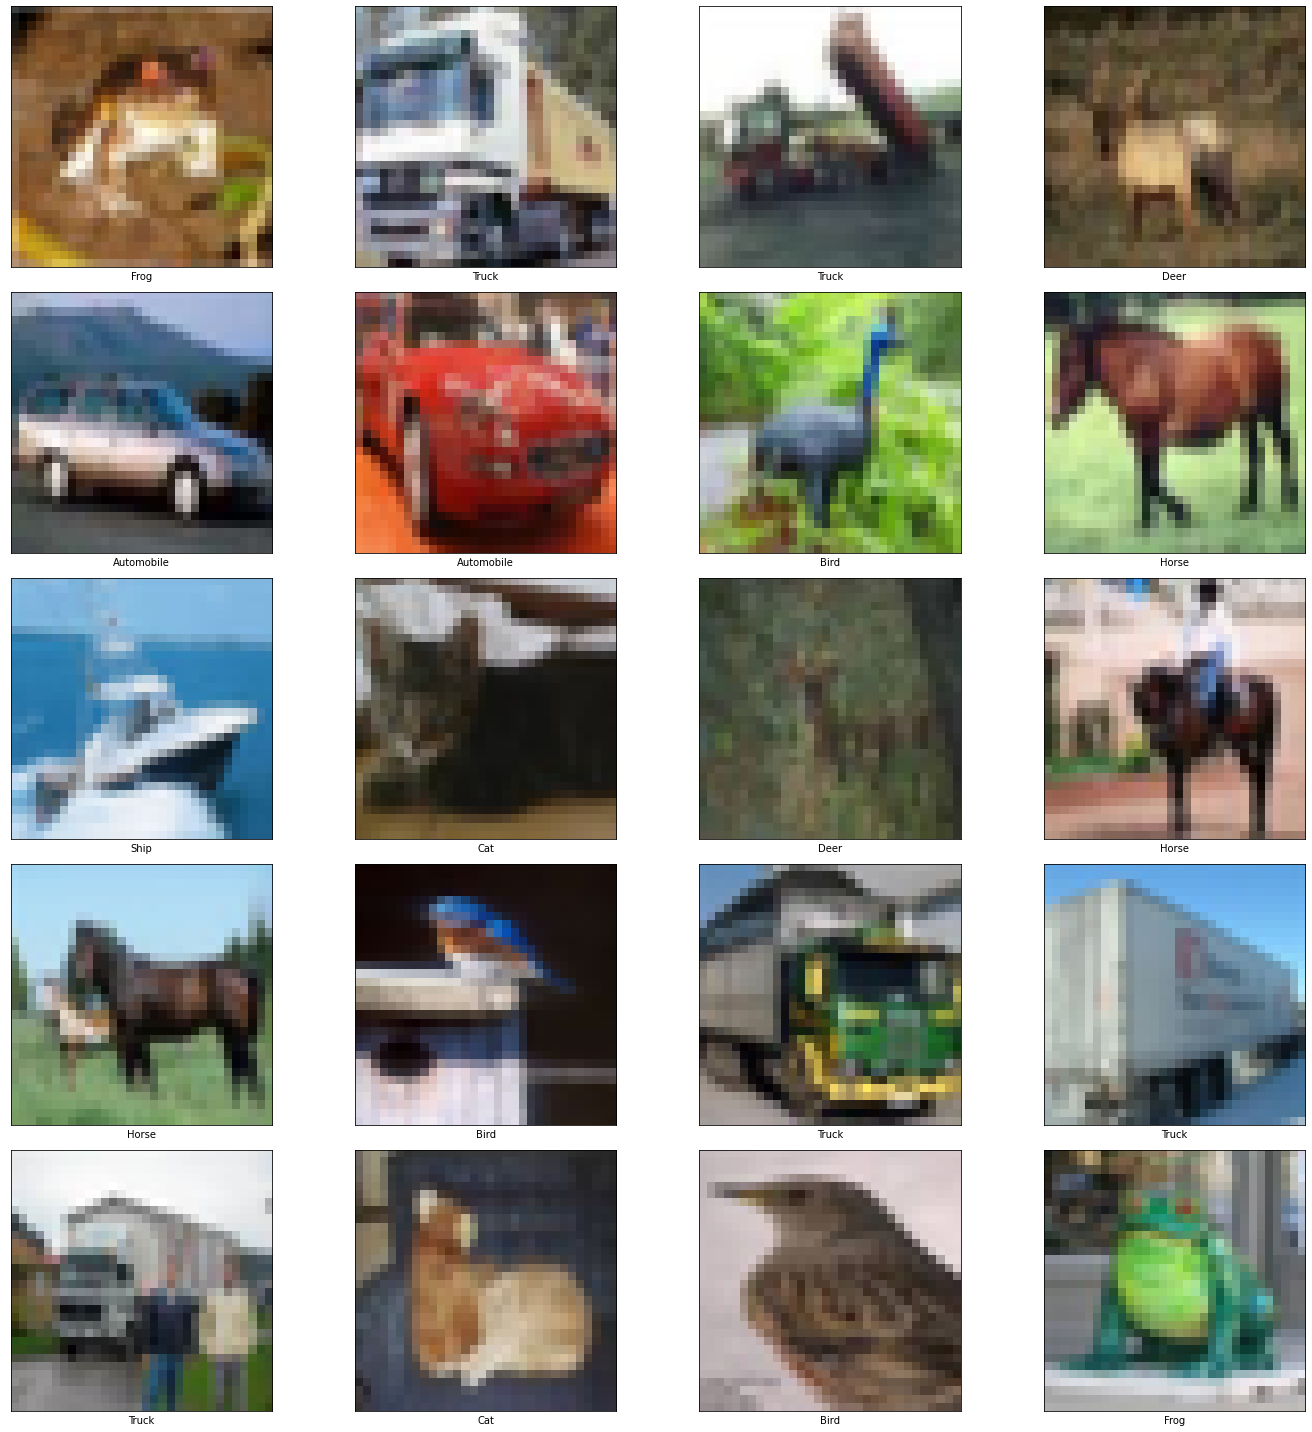

In [6]:
# Plotting sample images from each class
plt.figure(figsize=(20,20))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_imgs[i], cmap='gray')
    plt.xlabel(class_names[train_labels[i][0]])
plt.tight_layout()    
plt.show()

In [7]:
# Encoding the labels using One Hot Encoder
train_labels_encoded = tf.keras.utils.to_categorical(train_labels, num_classes=10, dtype='uint8')
test_labels_encoded = tf.keras.utils.to_categorical(test_labels, num_classes=10, dtype='uint8')

### Model Building
---
- Data split into train and validation sets
- Data augmentation
- Model architecture blocks

In [8]:
# Splitting the dataset into train and validation sets
train_imgs, validation_imgs, train_labels, validation_labels = train_test_split(train_imgs, train_labels_encoded,
                                                                                test_size=0.2,
                                                                                random_state=21,
                                                                                shuffle=True,
                                                                                stratify=train_labels_encoded
                                                                                )
print(f'Training data size: {train_imgs.shape}')
print(f'Validation data size: {validation_imgs.shape}')

Training data size: (40000, 32, 32, 3)
Validation data size: (10000, 32, 32, 3)


In [9]:
# Data augmentation
train_imgs_new = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2,
                                                                     height_shift_range=0.2, 
                                                                     width_shift_range=0.2, 
                                                                     horizontal_flip=True
                                                                     )
validation_imgs_new = tf.keras.preprocessing.image.ImageDataGenerator()

batch_size = 128

train_imgs_final = train_imgs_new.flow(train_imgs, train_labels, batch_size=batch_size)
validation_imgs_final = validation_imgs_new.flow(validation_imgs, validation_labels, batch_size=batch_size)

In [10]:
# ResNet identity block
def resnet_id_block(x, filters): 
  ''' 
  The ResNet identity block. The dimension does not change.
  '''
  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  x = BatchNormalization()(x)

  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [11]:
# ResNet convolution block
def resnet_conv_block(x, s, filters):
  '''
  ResNet convolution block. The dimension changes for input.
  ''' 
  x_skip = x
  f1, f2 = filters

  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid')(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  x = BatchNormalization()(x)

  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid')(x_skip)
  x_skip = BatchNormalization()(x_skip)

  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [12]:
# Full Model Architecture
def resnet50():
  '''
  Full architecture of ResNet50
  '''

  input_img = Input(shape=(train_imgs.shape[1], train_imgs.shape[2], train_imgs.shape[3]))
  x = ZeroPadding2D(padding=(3, 3))(input_img)

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  x = resnet_conv_block(x, s=1, filters=(64, 256))
  x = resnet_id_block(x, filters=(64, 256))
  x = resnet_id_block(x, filters=(64, 256))

  x = resnet_conv_block(x, s=2, filters=(128, 512))
  x = resnet_id_block(x, filters=(128, 512))
  x = resnet_id_block(x, filters=(128, 512))
  x = resnet_id_block(x, filters=(128, 512))

  x = resnet_conv_block(x, s=2, filters=(256, 1024))
  x = resnet_id_block(x, filters=(256, 1024))
  x = resnet_id_block(x, filters=(256, 1024))
  x = resnet_id_block(x, filters=(256, 1024))
  x = resnet_id_block(x, filters=(256, 1024))
  x = resnet_id_block(x, filters=(256, 1024))

  x = resnet_conv_block(x, s=2, filters=(512, 2048))
  x = resnet_id_block(x, filters=(512, 2048))
  x = resnet_id_block(x, filters=(512, 2048))

  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  x = Dense(len(class_names), activation='softmax', kernel_initializer='he_normal')(x)

  model = Model(inputs=input_img, outputs=x, name='Resnet50')

  return model


Model: "Resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                

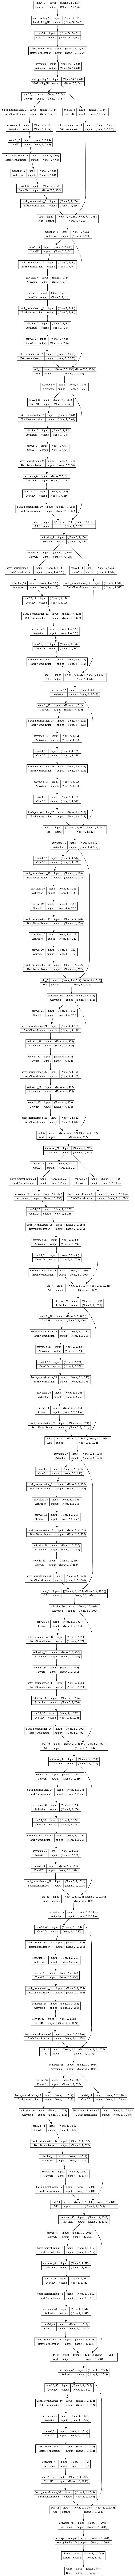

In [13]:
resnet50_model = resnet50()
resnet50_model.summary()
plot_model(resnet50_model, show_shapes=True, show_layer_names=True)

In [14]:
resnet50_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
                       metrics=['acc'])

In [15]:
batch_size=batch_size

resnet_model_train = resnet50_model.fit(train_imgs_final, 
                                        epochs=150, 
                                        steps_per_epoch=train_imgs.shape[0]/batch_size, 
                                        validation_steps=validation_imgs.shape[0]/batch_size, 
                                        validation_data=validation_imgs_final, 
                                       )

Epoch 1/150
312/312 [==============================] - 46s 112ms/step - loss: 2.0316 - acc: 0.3169 - val_loss: 3.0531 - val_acc: 0.1440
Epoch 2/150
312/312 [==============================] - 33s 105ms/step - loss: 1.8499 - acc: 0.3650 - val_loss: 1.8102 - val_acc: 0.3431
Epoch 3/150
312/312 [==============================] - 28s 90ms/step - loss: 1.8402 - acc: 0.3808 - val_loss: 423.4754 - val_acc: 0.1196
Epoch 4/150
312/312 [==============================] - 27s 86ms/step - loss: 2.0024 - acc: 0.3401 - val_loss: 10.1318 - val_acc: 0.2613
Epoch 5/150
312/312 [==============================] - 28s 89ms/step - loss: 1.8252 - acc: 0.3810 - val_loss: 37.9066 - val_acc: 0.2885
Epoch 6/150
312/312 [==============================] - 27s 86ms/step - loss: 1.8006 - acc: 0.3797 - val_loss: 1.7386 - val_acc: 0.3918
Epoch 7/150
312/312 [==============================] - 27s 86ms/step - loss: 1.8376 - acc: 0.3859 - val_loss: 27.8396 - val_acc: 0.0827
Epoch 8/150
312/312 [===========================

### Results
---
- Plots of training and validation loss
- Plots of training and validation accuracy
- Model performance on test data

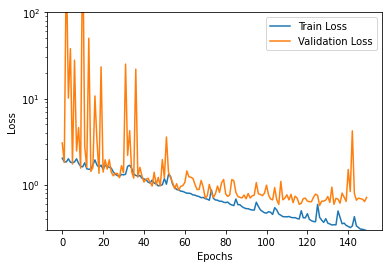

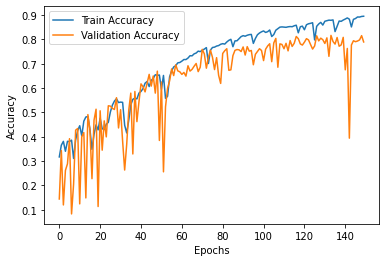

In [20]:
# Plots of training and validation loss


train_loss = resnet_model_train.history['loss']
validation_loss = resnet_model_train.history['val_loss']
epochs = range(len(train_loss))
plt.figure()
plt.yscale('log')
plt.plot(epochs, train_loss, linestyle='-', label='Train Loss')
plt.plot(epochs, validation_loss, linestyle='-', label='Validation Loss')
plt.ylim(0.3, 100)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


train_acc = resnet_model_train.history['acc']
validation_acc = resnet_model_train.history['val_acc']
plt.figure()
plt.plot(epochs, train_acc, linestyle='-', label='Train Accuracy')
plt.plot(epochs, validation_acc, linestyle='-', label='Validation Accuracy') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
# Model performance on test data
test_result = resnet50_model.evaluate(test_imgs, test_labels_encoded, verbose=0)

print ("Test loss: ", test_result[0])
print ("Test accuracy: ", test_result[1])


Test loss:  0.7557961344718933
Test accuracy:  0.7875999808311462
